# Model Tuning

## Imports and Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from prophet import Prophet

c:\Users\dsigl\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
eg_df = pd.read_csv('../data/evergreen-visits.csv', parse_dates=['Visit Date', 'Visit Time In', 'Visit Time Out'])
sb_df = pd.read_csv('../data/steamboat-visits.csv', parse_dates=['Visit Date', 'Visit Time In', 'Visit Time Out'])
# ch_df = pd.read_csv('../data/charleston-visits.csv', parse_dates=['Visit Date', 'Visit Time In', 'Visit Time Out'])

In [75]:
# group to visits per day
sb_visits_per_day = sb_df.groupby('Visit Date').count().rename({'Visit Time In': 'visits'}, axis=1).drop(['Visit Time Out', 'Visit Program'], axis=1).reset_index()
eg_visits_per_day = eg_df.groupby('Visit Date').count().rename({'Visit Time In': 'visits'}, axis=1).drop(['Visit Time Out', 'Visit Program'], axis=1).reset_index()

In [76]:
# prepare for prophet model
sb_visits_per_day = sb_visits_per_day.rename({'Visit Date': 'ds', 'visits':'y'}, axis=1)
eg_visits_per_day = eg_visits_per_day.rename({'Visit Date': 'ds', 'visits':'y'}, axis=1)

In [77]:
# extend Eg data with prior Sb data
df_to_concat = sb_visits_per_day.copy()
df_to_concat['ds'] = df_to_concat['ds'] + pd.DateOffset(years=8)

co_visits_per_day = pd.concat([eg_visits_per_day, df_to_concat[df_to_concat['ds'] < eg_visits_per_day['ds'].min()]]).sort_values(by='ds')

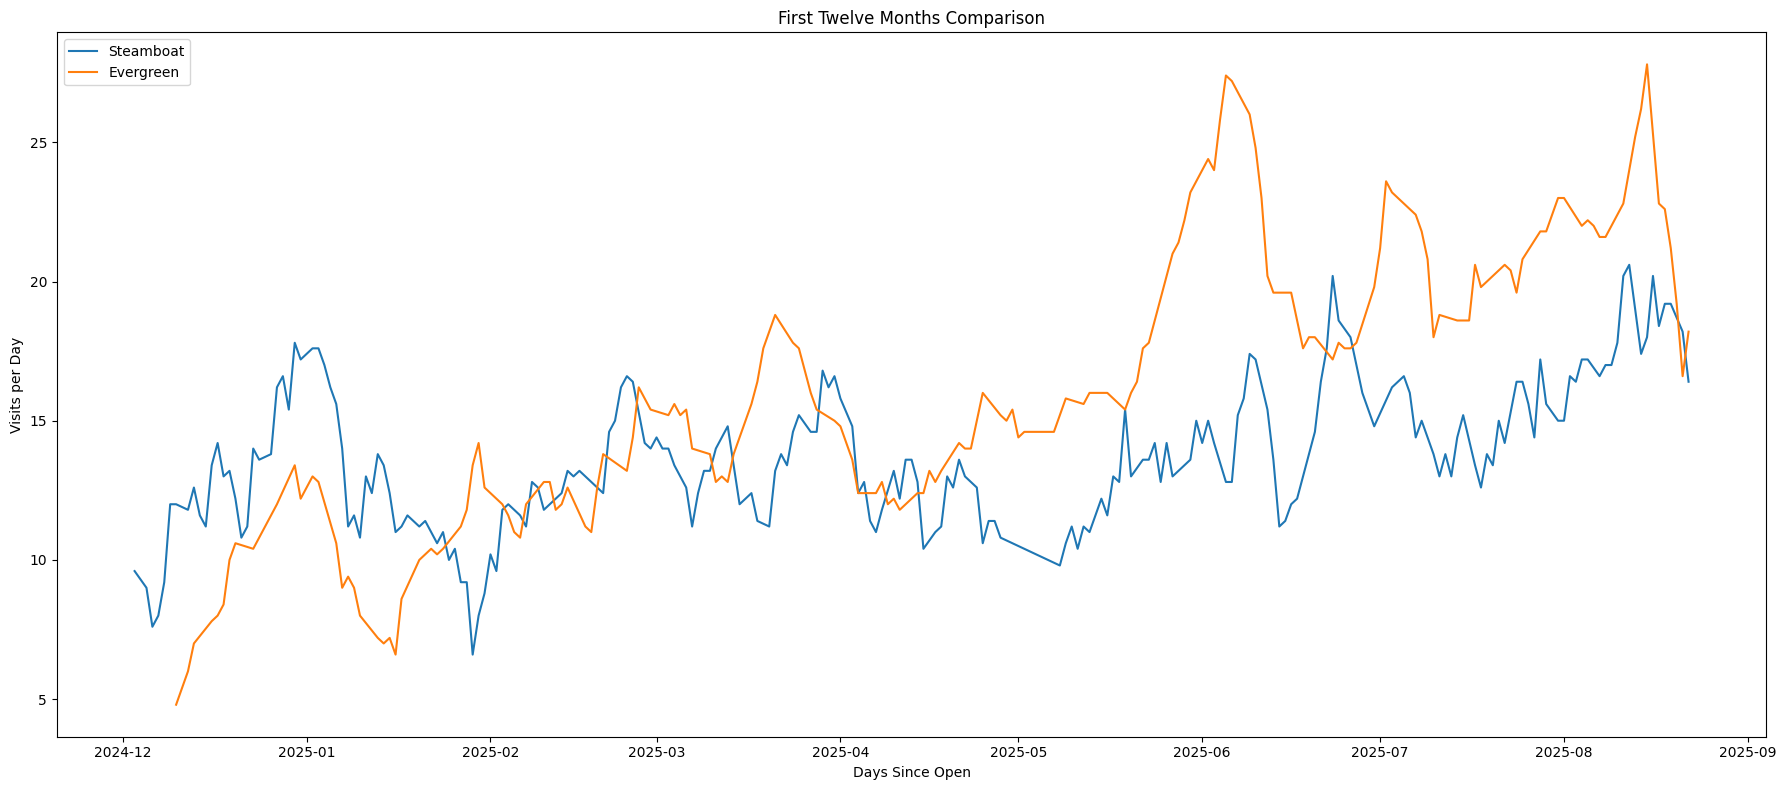

In [60]:
fig = plt.figure(figsize=(18,8))

sb_first_year = sb_visits_per_day.copy()
sb_first_year['adjusted_date'] = sb_first_year['ds'] + pd.DateOffset(years=8)
sb_first_year = sb_first_year.drop(columns='ds').set_index('adjusted_date')
sb_first_year['rolling_avg'] = sb_first_year['y'].rolling(window=5).mean()

# slice df to compare apples to apples
sb_df_to_compare = sb_first_year[eg_visits_per_day['ds'].min():eg_visits_per_day['ds'].max()]

plt.plot(sb_df_to_compare.index, sb_df_to_compare['rolling_avg'], label='Steamboat')
plt.plot(eg_visits_per_day['ds'], eg_visits_per_day['y'].rolling(window=5).mean(), label='Evergreen')

plt.legend()
plt.title('First Twelve Months Comparison')
plt.xlabel('Days Since Open')
plt.ylabel('Visits per Day')

plt.tight_layout()
plt.show();

## Train/Test Split

In [96]:
cut_off_date = pd.Timestamp('2025-06-01')

train_df = co_visits_per_day.loc[co_visits_per_day['ds'] < cut_off_date].copy()
test_df = co_visits_per_day.loc[co_visits_per_day['ds'] >= cut_off_date].copy()

## Holidays and Custom "Seasons"

Adding school-year summers

In [102]:
def is_school_summer(ds):
    date = pd.to_datetime(ds)
    return (date.month > 5 and date.month < 9)

train_df['is_summer'] = train_df['ds'].apply(is_school_summer)

## Evergreen Forecasting

In [103]:
model = Prophet(growth='logistic', weekly_seasonality=False)
model.add_country_holidays('US')
model.add_seasonality('monthly', period=30.5, fourier_order=5)

# school-year summers
model.add_seasonality(name='school_year_out',
                      period=365,
                      fourier_order=10,
                      condition_name='is_summer')

# The maximum possible visits per day based on regulations, size
train_df['cap'] = 40 
test_df['cap'] = 40

model.fit(train_df)

21:21:04 - cmdstanpy - INFO - Chain [1] start processing
21:21:04 - cmdstanpy - INFO - Chain [1] done processing


In [108]:
future = model.make_future_dataframe(periods=90)
future['cap'] = 40
future['is_summer'] = future['ds'].apply(is_school_summer)

fcst = model.predict(future)

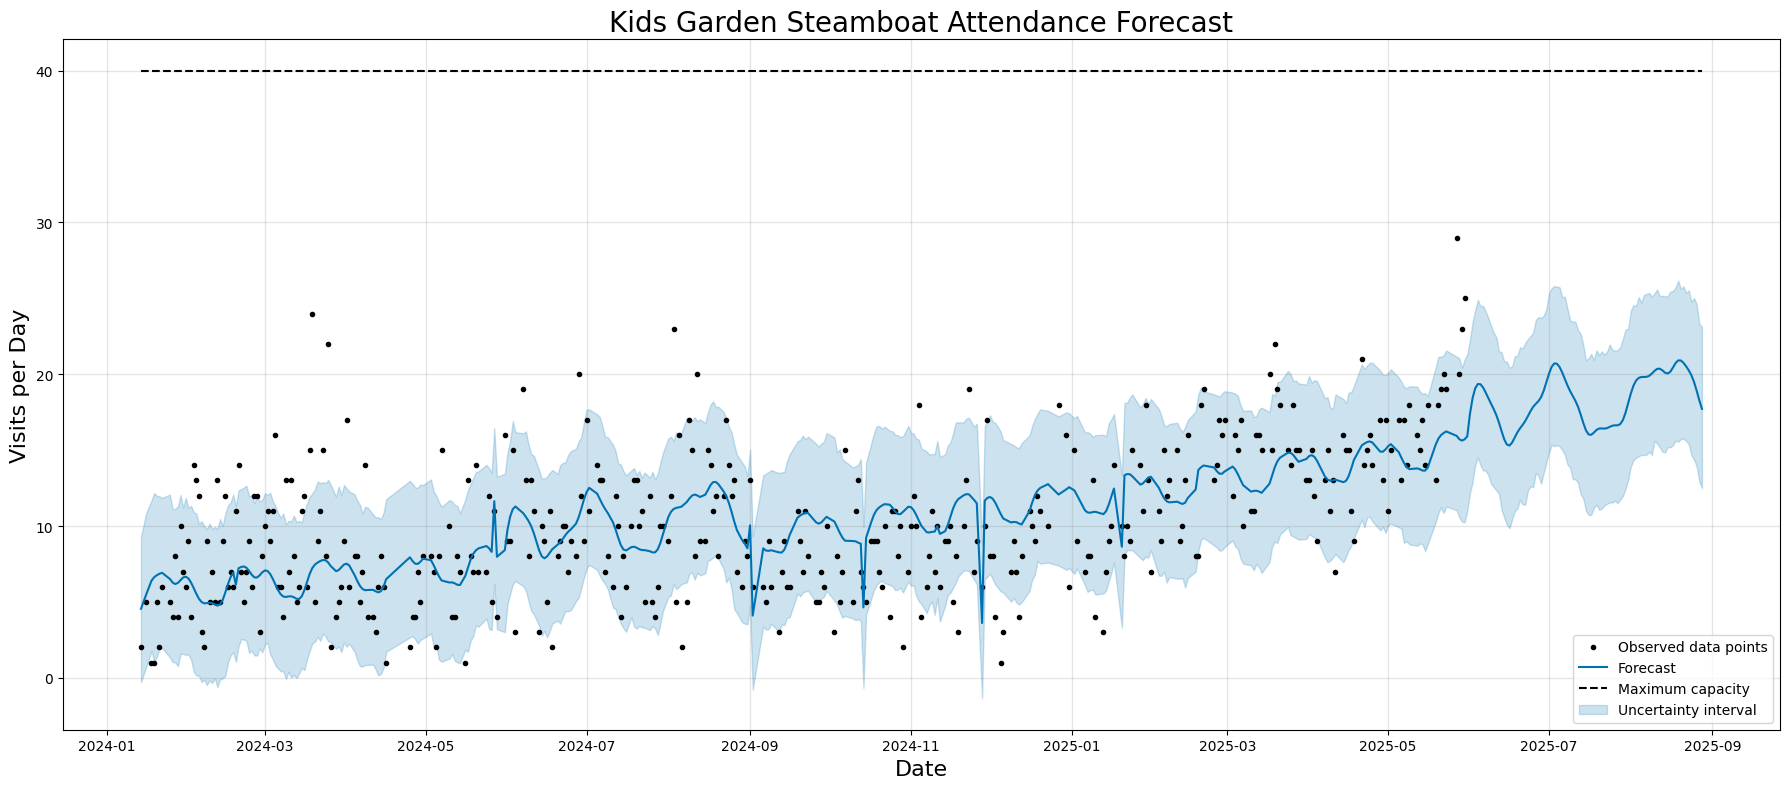

In [110]:
model.plot(fcst, figsize=(18,8))

plt.title('Kids Garden Steamboat Attendance Forecast', size=20)
plt.xlabel('Date', size=16)
plt.ylabel('Visits per Day', size=16)
plt.legend()
plt.tight_layout()
plt.show();

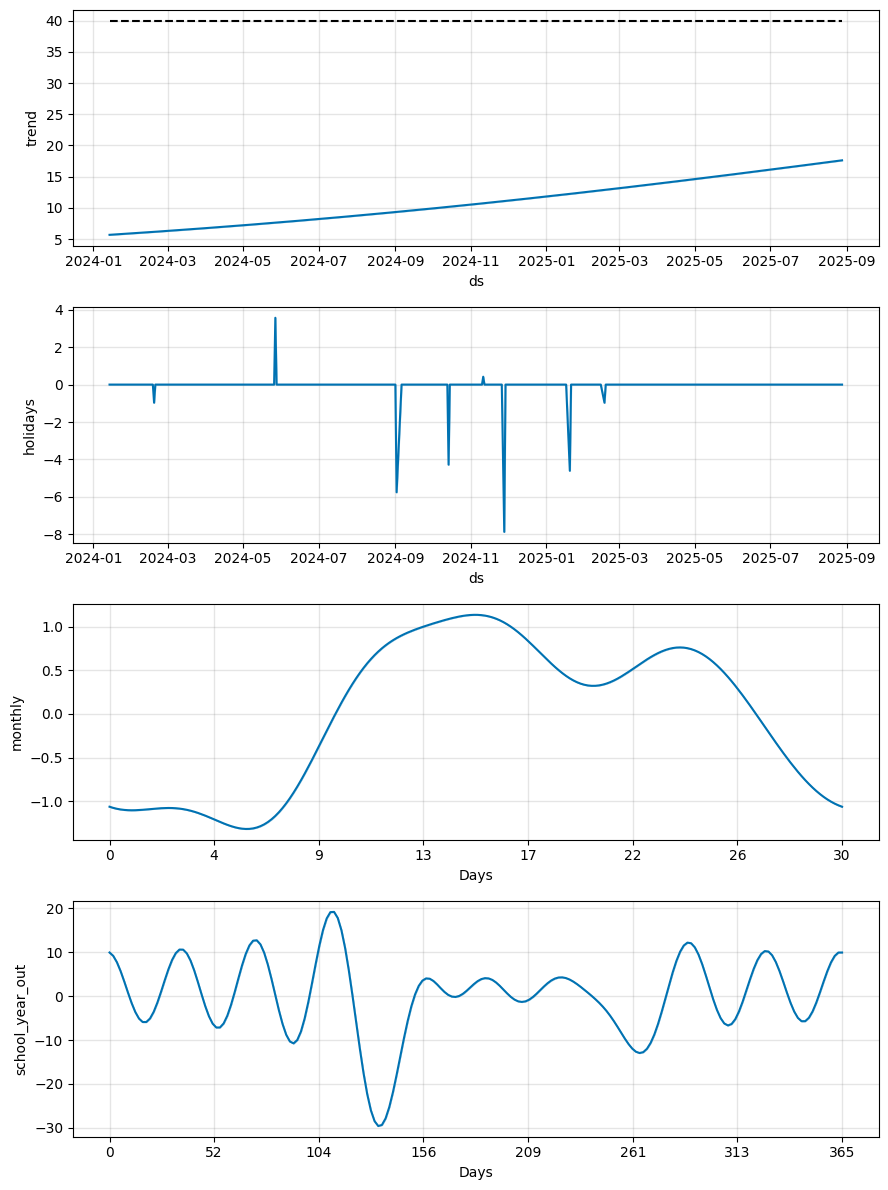

In [111]:
fig = model.plot_components(fcst)

## Model Evaluation